# normal_model

## time pyd_data

## 原始数据读取

In [130]:
import pandas as pd

# ===================== 1️⃣ CWT 路径 =====================
cwt_train_csv = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT/train/train_CWT.csv"
cwt_val_csv   = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT/val/val_CWT.csv"
cwt_test_csv  = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT/test/test_CWT.csv"

# ===================== 2️⃣ current&temp（已对齐）路径 =====================
ct_root = "/home/charles/HZU/Data_processed/HSML/KAIST/current&temp_raw_wl_5000/aligned_with_CWT"

ct_train_csv = f"{ct_root}/train_current&temp.csv"
ct_val_csv   = f"{ct_root}/val_current&temp.csv"
ct_test_csv  = f"{ct_root}/test_current&temp.csv"

# ===================== 3️⃣ 读取 =====================
cwt_train_df = pd.read_csv(cwt_train_csv)
cwt_val_df   = pd.read_csv(cwt_val_csv)
cwt_test_df  = pd.read_csv(cwt_test_csv)

ct_train_df  = pd.read_csv(ct_train_csv)
ct_val_df    = pd.read_csv(ct_val_csv)
ct_test_df   = pd.read_csv(ct_test_csv)

# ===================== 4️⃣ 基本信息检查 =====================
print("=== CWT ===")
print("Train:", cwt_train_df.shape)
print("Val  :", cwt_val_df.shape)
print("Test :", cwt_test_df.shape)

print("\n=== Current & Temp (Aligned) ===")
print("Train:", ct_train_df.shape)
print("Val  :", ct_val_df.shape)
print("Test :", ct_test_df.shape)


=== CWT ===
Train: (1756, 126)
Val  : (291, 126)
Test : (877, 126)

=== Current & Temp (Aligned) ===
Train: (1756, 7)
Val  : (291, 7)
Test : (877, 7)


## 六个集图结构搭建

In [131]:
# ===================== 单cell：CWT & CT 列归一化 -> 六个数据集构图并保存到 MMFD =====================
import os
import numpy as np
import pandas as pd
import torch

# --------------------- 输出目录 ---------------------
out_root = "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD"
os.makedirs(out_root, exist_ok=True)

# --------------------- 输入路径 ---------------------
cwt_root = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT"
ct_root  = "/home/charles/HZU/Data_processed/HSML/KAIST/current&temp_raw_wl_5000/aligned_with_CWT"

paths = {
    "cwt_train": f"{cwt_root}/train/train_CWT.csv",
    "cwt_val":   f"{cwt_root}/val/val_CWT.csv",
    "cwt_test":  f"{cwt_root}/test/test_CWT.csv",
    "ct_train":  f"{ct_root}/train_current&temp.csv",
    "ct_val":    f"{ct_root}/val_current&temp.csv",
    "ct_test":   f"{ct_root}/test_current&temp.csv",
}

# --------------------- 图参数 ---------------------
k = 10
tau = 2.0
eps = 1e-6

def weight_from_dist(dist):
    return np.exp(-dist / tau).astype(np.float32)

def build_temporal_k_graph(num_nodes, k):
    k_up = k // 2
    k_dn = k - k_up

    src, dst, dist = [], [], []

    for i in range(num_nodes):
        for d in range(1, k_up + 1):
            j = i - d
            if j < 0: break
            src.append(i); dst.append(j); dist.append(d)

        for d in range(1, k_dn + 1):
            j = i + d
            if j >= num_nodes: break
            src.append(i); dst.append(j); dist.append(d)

    src = np.array(src, dtype=np.int64)
    dst = np.array(dst, dtype=np.int64)
    dist = np.array(dist, dtype=np.float32)

    w = weight_from_dist(dist)

    edge_index = torch.tensor(
        np.stack([np.concatenate([src, dst]), np.concatenate([dst, src])], axis=0),
        dtype=torch.long
    )
    edge_weight = torch.tensor(np.concatenate([w, w]), dtype=torch.float32)

    return edge_index, edge_weight

# --------------------- 主流程 ---------------------
for name, csv_path in paths.items():
    print(f"\n=== Processing {name} ===")
    df = pd.read_csv(csv_path)

    # 1️⃣ 特征 / 标签分离
    X_df = df.iloc[:, :-1].copy()
    y_df = df.iloc[:, -1].copy()

    # 2️⃣ 删除 NaN 列（CT 通常有，CWT 保险起见也统一处理）
    nan_cols = X_df.columns[X_df.isna().any(axis=0)]
    X_df = X_df.drop(columns=nan_cols)
    if len(nan_cols) > 0:
        print(f"Removed NaN columns: {len(nan_cols)}")

    # 3️⃣ 列归一化（Z-score）—— CWT & CT 统一
    col_mean = X_df.mean(axis=0)
    col_std  = X_df.std(axis=0)
    X_df = (X_df - col_mean) / (col_std + eps)

    print("Feature-wise normalization applied")

    X = torch.tensor(X_df.values, dtype=torch.float32)
    y = torch.tensor(y_df.values, dtype=torch.long)

    print(f"X shape: {tuple(X.shape)}, y shape: {tuple(y.shape)}")

    # 4️⃣ 构图
    edge_index, edge_weight = build_temporal_k_graph(X.shape[0], k)
    print(f"Graph edges: {edge_index.shape[1]}")

    # 5️⃣ 保存
    save_dict = {
        "x": X,
        "y": y,
        "edge_index": edge_index,
        "edge_weight": edge_weight,
    }

    save_path = os.path.join(out_root, f"{name}_graph.pt")
    torch.save(save_dict, save_path)
    print(f"Saved to: {save_path}")

print("\n✅ CWT & CT 列归一化 + 六个数据集图结构已全部保存到 MMFD")



=== Processing cwt_train ===
Feature-wise normalization applied
X shape: (1756, 125), y shape: (1756,)
Graph edges: 35060
Saved to: /home/charles/HZU/Data_processed/HSML/KAIST/MMFD/cwt_train_graph.pt

=== Processing cwt_val ===
Feature-wise normalization applied
X shape: (291, 125), y shape: (291,)
Graph edges: 5760
Saved to: /home/charles/HZU/Data_processed/HSML/KAIST/MMFD/cwt_val_graph.pt

=== Processing cwt_test ===
Feature-wise normalization applied
X shape: (877, 125), y shape: (877,)
Graph edges: 17480
Saved to: /home/charles/HZU/Data_processed/HSML/KAIST/MMFD/cwt_test_graph.pt

=== Processing ct_train ===
Removed NaN columns: 2
Feature-wise normalization applied
X shape: (1756, 4), y shape: (1756,)
Graph edges: 35060
Saved to: /home/charles/HZU/Data_processed/HSML/KAIST/MMFD/ct_train_graph.pt

=== Processing ct_val ===
Removed NaN columns: 2
Feature-wise normalization applied
X shape: (291, 4), y shape: (291,)
Graph edges: 5760
Saved to: /home/charles/HZU/Data_processed/HSML/KA

## 数据打包

In [132]:
# ===================== 单cell：MMFD 六个图数据打包为 PyG DataLoader =====================
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import os

# --------------------- 1️⃣ MMFD 图文件路径 ---------------------
MMFD_ROOT = "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD"

graph_files = {
    # CWT
    "cwt_train": f"{MMFD_ROOT}/cwt_train_graph.pt",
    "cwt_val":   f"{MMFD_ROOT}/cwt_val_graph.pt",
    "cwt_test":  f"{MMFD_ROOT}/cwt_test_graph.pt",
    # Current & Temp
    "ct_train":  f"{MMFD_ROOT}/ct_train_graph.pt",
    "ct_val":    f"{MMFD_ROOT}/ct_val_graph.pt",
    "ct_test":   f"{MMFD_ROOT}/ct_test_graph.pt",
}

# --------------------- 2️⃣ 加载 .pt → PyG Data ---------------------
def load_graph_as_pyg_data(pt_path):
    assert os.path.exists(pt_path), f"File not found: {pt_path}"
    obj = torch.load(pt_path, map_location="cpu")

    data = Data(
        x=obj["x"],
        edge_index=obj["edge_index"],
        y=obj["y"]
    )

    # 如果有 edge_weight，作为 edge_attr
    if "edge_weight" in obj and obj["edge_weight"] is not None:
        data.edge_attr = obj["edge_weight"].unsqueeze(-1)

    return data


data_dict = {}
for name, path in graph_files.items():
    data = load_graph_as_pyg_data(path)
    data_dict[name] = data
    print(f"[Loaded] {name}: x={tuple(data.x.shape)}, edges={data.edge_index.shape[1]}")

# --------------------- 3️⃣ 构造 DataLoader（batch_size=1，对齐你的 GCL 代码） ---------------------
def build_loader(data, shuffle=True):
    return DataLoader([data], batch_size=1, shuffle=shuffle)

# CWT
cwt_loader      = build_loader(data_dict["cwt_train"], shuffle=True)
cwt_val_loader  = build_loader(data_dict["cwt_val"],   shuffle=False)
cwt_test_loader = build_loader(data_dict["cwt_test"],  shuffle=False)

# CT
ct_loader      = build_loader(data_dict["ct_train"], shuffle=True)
ct_val_loader  = build_loader(data_dict["ct_val"],   shuffle=False)
ct_test_loader = build_loader(data_dict["ct_test"],  shuffle=False)

print("\n✅ MMFD 六个图数据已全部打包为 PyG DataLoader")


[Loaded] cwt_train: x=(1756, 125), edges=35060
[Loaded] cwt_val: x=(291, 125), edges=5760
[Loaded] cwt_test: x=(877, 125), edges=17480
[Loaded] ct_train: x=(1756, 4), edges=35060
[Loaded] ct_val: x=(291, 4), edges=5760
[Loaded] ct_test: x=(877, 4), edges=17480

✅ MMFD 六个图数据已全部打包为 PyG DataLoader


/tmp/ipykernel_28207/1949068153.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pt_path, map_location="cpu")


# GCL模型

## 模型初始化

In [133]:
# ===================== 单cell：为两个模态定义两个独立的 GCL 模型 =====================
import sys
import torch

# --------------------- 1️⃣ 导入 models.py ---------------------
MODEL_DIR = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/src"
sys.path.append(MODEL_DIR)

from models import GraphContrastiveLearner

print("✅ models.py imported")

# --------------------- 2️⃣ 设备 ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------- 3️⃣ 从已保存图中读取特征维度（强烈推荐） ---------------------
cwt_graph = torch.load(
    "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD/cwt_train_graph.pt",
    map_location="cpu"
)
ct_graph = torch.load(
    "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD/ct_train_graph.pt",
    map_location="cpu"
)

cwt_in_dim = cwt_graph["x"].shape[1]
ct_in_dim  = ct_graph["x"].shape[1]

print(f"CWT feature dim: {cwt_in_dim}")
print(f"CT  feature dim: {ct_in_dim}")

# --------------------- 4️⃣ 分别定义两个 GCL 模型 ---------------------

# ===== CWT 模态 =====
gcl_cwt = GraphContrastiveLearner(
    in_dim=cwt_in_dim,
    hidden_dim=256,
    out_dim=128,
    proj_dim=128,
    tau=0.5
).to(device)

# ===== Current & Temp 模态 =====
gcl_ct = GraphContrastiveLearner(
    in_dim=ct_in_dim,
    hidden_dim=128,     # 通常 CT 不需要太宽
    out_dim=64,
    proj_dim=64,
    tau=0.5
).to(device)

print("\n✅ Two independent GCL models initialized")
print("GCL_CWT:\n", gcl_cwt)
print("\nGCL_CT:\n", gcl_ct)


✅ models.py imported
Using device: cuda
CWT feature dim: 125
CT  feature dim: 4

✅ Two independent GCL models initialized
GCL_CWT:
 GraphContrastiveLearner(
  (encoder): GCNEncoder(
    (conv1): SAGEConv(125, 256, aggr=mean)
    (conv2): SAGEConv(256, 128, aggr=mean)
  )
  (projector): MLPHead(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=128, out_features=128, bias=True)
  )
)

GCL_CT:
 GraphContrastiveLearner(
  (encoder): GCNEncoder(
    (conv1): SAGEConv(4, 128, aggr=mean)
    (conv2): SAGEConv(128, 64, aggr=mean)
  )
  (projector): MLPHead(
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=64, out_features=64, bias=True)
  )
)


/tmp/ipykernel_28207/1859979842.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_graph = torch.load(
/tmp/ipykernel_28207/1859979842.py:22: FutureWarning: You are us

## 训练

In [134]:
# ===================== 单cell：CWT / CT 两个模态分别进行 Batch GCL 训练 =====================
import os
import torch

# --------------------- 学习率设置（按模态区分，经验上更稳） ---------------------
lr_cwt = 1e-3      # CWT 特征维度高，稍微保守
lr_ct  = 2e-3      # CT 维度低，可以稍微快一点
weight_decay = 1e-5

# --------------------- CWT 模态优化器 ---------------------
optimizer_cwt = torch.optim.Adam(
    gcl_cwt.parameters(),
    lr=lr_cwt,
    weight_decay=weight_decay
)

# --------------------- CT 模态优化器 ---------------------
optimizer_ct = torch.optim.Adam(
    gcl_ct.parameters(),
    lr=lr_ct,
    weight_decay=weight_decay
)

print("✅ Optimizers initialized")
print(f"optimizer_cwt: lr={lr_cwt}, weight_decay={weight_decay}")
print(f"optimizer_ct : lr={lr_ct}, weight_decay={weight_decay}")

# --------------------- 0️⃣ 基本准备 ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200

# augment_graph 已在 models.py 中定义
from models import augment_graph

# ===================== 1️⃣ 通用训练函数（完全复用你的逻辑） =====================
def train_gcl_single_modal(
    model,
    loader,
    optimizer,
    save_dir,
    model_name,
    in_dim,
    hidden_dim,
    out_dim,
    proj_dim,
    tau
):
    os.makedirs(save_dir, exist_ok=True)

    best_loss = float("inf")
    best_model_path = os.path.join(save_dir, f"{model_name}_best.pt")

    print(f"\n================= 🚀 开始 {model_name} GCL 预训练 =================\n")

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for batch_data in loader:
            batch_data = batch_data[0].to(device)   # batch_size=1

            # ---- 两份增强视图 ----
            data1 = augment_graph(
                batch_data,
                feature_drop_prob=0.2,
                edge_drop_prob=0.1,
                noise_std=0.02
            ).to(device)

            data2 = augment_graph(
                batch_data,
                feature_drop_prob=0.2,
                edge_drop_prob=0.1,
                noise_std=0.02
            ).to(device)

            # ---- 对比损失 ----
            loss = model.compute_loss(
                data1.x, data1.edge_index,
                data2.x, data2.edge_index
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # ---- 日志 ----
        if epoch % 10 == 0:
            print(f"[{model_name}] Epoch [{epoch:03d}/{epochs}] | InfoNCE Loss: {total_loss:.4f}")

        # ---- 保存最优模型 ----
        if total_loss < best_loss:
            best_loss = total_loss
            torch.save({
                "model_state_dict": model.state_dict(),
                "best_loss": best_loss,
                "epoch": epoch,
                "config": {
                    "in_dim": in_dim,
                    "hidden_dim": hidden_dim,
                    "out_dim": out_dim,
                    "proj_dim": proj_dim,
                    "tau": tau
                }
            }, best_model_path)

            print(f"💾 [{model_name} BEST] Epoch {epoch} | Loss={total_loss:.4f}")

    # ---- 保存最终模型 ----
    final_path = os.path.join(save_dir, f"{model_name}_epoch{epochs}.pt")
    torch.save({
        "model_state_dict": model.state_dict(),
        "epoch": epochs,
        "config": {
            "in_dim": in_dim,
            "hidden_dim": hidden_dim,
            "out_dim": out_dim,
            "proj_dim": proj_dim,
            "tau": tau
        }
    }, final_path)

    print(f"\n🏁 [{model_name}] 最终模型保存至: {final_path}")
    print(f"🏆 [{model_name}] 最优模型保存至: {best_model_path} | best_loss={best_loss:.4f}")


# ===================== 2️⃣ CWT 模态训练 =====================
train_gcl_single_modal(
    model=gcl_cwt,
    loader=cwt_loader,          # ⚠️ 你提前构建好的 DataLoader
    optimizer=optimizer_cwt,    # ⚠️ 对应 gcl_cwt 的 optimizer
    save_dir="/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/ckpt_cwt",
    model_name="CWT_GCL",
    in_dim=cwt_in_dim,
    hidden_dim=256,
    out_dim=128,
    proj_dim=128,
    tau=0.5
)

# ===================== 3️⃣ Current & Temp 模态训练 =====================
train_gcl_single_modal(
    model=gcl_ct,
    loader=ct_loader,           # ⚠️ 对应 CT 图的 DataLoader
    optimizer=optimizer_ct,     # ⚠️ 对应 gcl_ct 的 optimizer
    save_dir="/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/ckpt_ct",
    model_name="CT_GCL",
    in_dim=ct_in_dim,
    hidden_dim=128,
    out_dim=64,
    proj_dim=64,
    tau=0.5
)


✅ Optimizers initialized
optimizer_cwt: lr=0.001, weight_decay=1e-05
optimizer_ct : lr=0.002, weight_decay=1e-05

================= 🚀 开始 CWT_GCL GCL 预训练 =================



💾 [CWT_GCL BEST] Epoch 1 | Loss=32.5515
💾 [CWT_GCL BEST] Epoch 2 | Loss=32.2850
💾 [CWT_GCL BEST] Epoch 3 | Loss=32.1657
💾 [CWT_GCL BEST] Epoch 4 | Loss=32.0144
💾 [CWT_GCL BEST] Epoch 5 | Loss=31.8565
💾 [CWT_GCL BEST] Epoch 6 | Loss=31.7254
💾 [CWT_GCL BEST] Epoch 7 | Loss=31.6690
💾 [CWT_GCL BEST] Epoch 8 | Loss=31.6102
💾 [CWT_GCL BEST] Epoch 9 | Loss=31.5808
[CWT_GCL] Epoch [010/200] | InfoNCE Loss: 31.5241
💾 [CWT_GCL BEST] Epoch 10 | Loss=31.5241
💾 [CWT_GCL BEST] Epoch 11 | Loss=31.5091
💾 [CWT_GCL BEST] Epoch 12 | Loss=31.4729
💾 [CWT_GCL BEST] Epoch 13 | Loss=31.4638
💾 [CWT_GCL BEST] Epoch 14 | Loss=31.4471
💾 [CWT_GCL BEST] Epoch 15 | Loss=31.4305
💾 [CWT_GCL BEST] Epoch 16 | Loss=31.4160
💾 [CWT_GCL BEST] Epoch 17 | Loss=31.4057
💾 [CWT_GCL BEST] Epoch 18 | Loss=31.3905
💾 [CWT_GCL BEST] Epoch 19 | Loss=31.3836
[CWT_GCL] Epoch [020/200] | InfoNCE Loss: 31.3764
💾 [CWT_GCL BEST] Epoch 20 | Loss=31.3764
💾 [CWT_GCL BEST] Epoch 21 | Loss=31.3612
💾 [CWT_GCL BEST] Epoch 22 | Loss=31.3594
💾 [CWT_

## 效果可视化

CWT h shape: (1756, 128)
CT  h shape: (1756, 64)


/tmp/ipykernel_28207/2019439234.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_graph = torch.load(f"{MMFD_ROOT}/cwt_train_graph.pt", map_location=device)
/tmp/ipyk

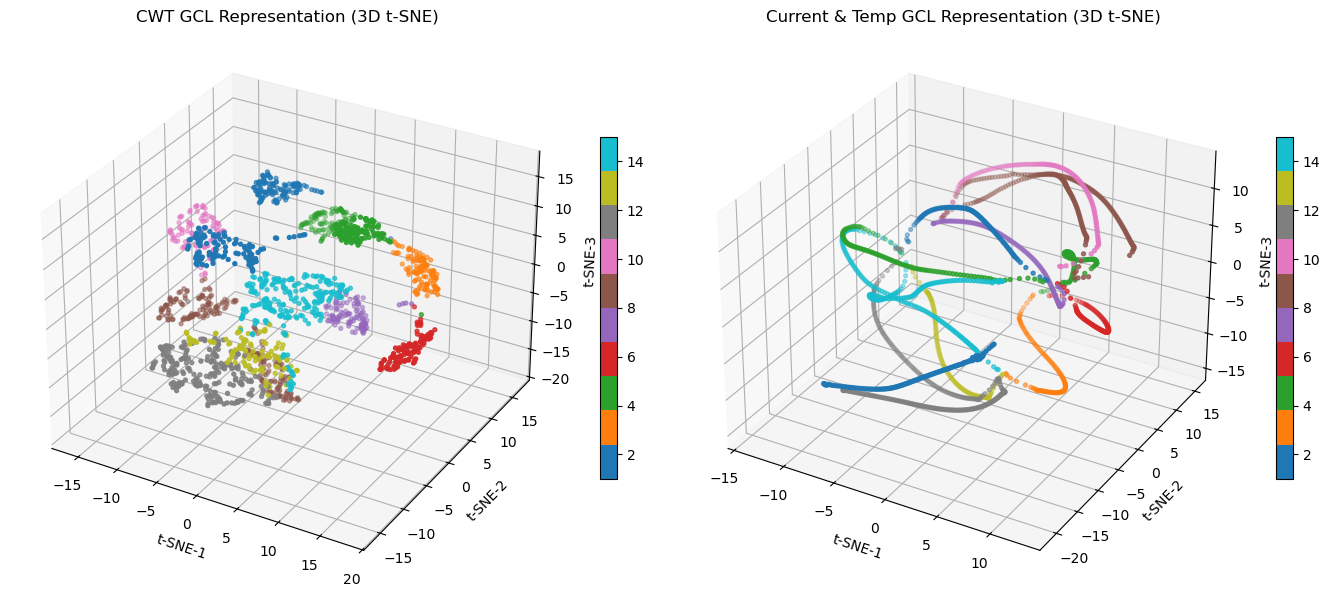

In [135]:
# ===================== 单cell：CWT / CT 两个模态 GCL 表征 3D 可视化 =====================
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------- 1️⃣ 从 MMFD 加载图数据（train 集） ---------------------
MMFD_ROOT = "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD"

cwt_graph = torch.load(f"{MMFD_ROOT}/cwt_train_graph.pt", map_location=device)
ct_graph  = torch.load(f"{MMFD_ROOT}/ct_train_graph.pt",  map_location=device)

# --------------------- 2️⃣ 封装成 PyG Data ---------------------
from torch_geometric.data import Data

def to_pyg_data(obj):
    return Data(
        x=obj["x"].to(device),
        edge_index=obj["edge_index"].to(device),
        y=obj["y"].to(device)
    )

cwt_data = to_pyg_data(cwt_graph)
ct_data  = to_pyg_data(ct_graph)

# --------------------- 3️⃣ 提取 encoder 表征 ---------------------
gcl_cwt.eval()
gcl_ct.eval()

with torch.no_grad():
    h_cwt, _ = gcl_cwt(cwt_data.x, cwt_data.edge_index)
    h_ct,  _ = gcl_ct(ct_data.x,  ct_data.edge_index)

h_cwt = h_cwt.cpu().numpy()
h_ct  = h_ct.cpu().numpy()

y_cwt = cwt_data.y.cpu().numpy()
y_ct  = ct_data.y.cpu().numpy()

print("CWT h shape:", h_cwt.shape)
print("CT  h shape:", h_ct.shape)

# --------------------- 4️⃣ t-SNE 降维（3D） ---------------------
tsne_cwt = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
z_cwt = tsne_cwt.fit_transform(h_cwt)

tsne_ct = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
z_ct = tsne_ct.fit_transform(h_ct)

# --------------------- 5️⃣ 3D 可视化 ---------------------
fig = plt.figure(figsize=(14, 6))

# ---- CWT ----
ax1 = fig.add_subplot(121, projection="3d")
p1 = ax1.scatter(
    z_cwt[:, 0], z_cwt[:, 1], z_cwt[:, 2],
    c=y_cwt, s=8, cmap="tab10"
)
ax1.set_title("CWT GCL Representation (3D t-SNE)")
ax1.set_xlabel("t-SNE-1")
ax1.set_ylabel("t-SNE-2")
ax1.set_zlabel("t-SNE-3")
fig.colorbar(p1, ax=ax1, shrink=0.6)

# ---- CT ----
ax2 = fig.add_subplot(122, projection="3d")
p2 = ax2.scatter(
    z_ct[:, 0], z_ct[:, 1], z_ct[:, 2],
    c=y_ct, s=8, cmap="tab10"
)
ax2.set_title("Current & Temp GCL Representation (3D t-SNE)")
ax2.set_xlabel("t-SNE-1")
ax2.set_ylabel("t-SNE-2")
ax2.set_zlabel("t-SNE-3")
fig.colorbar(p2, ax=ax2, shrink=0.6)

plt.tight_layout()
plt.show()


## 下游训练 

In [136]:
# ===================== 单cell：定义 train_data_cwt / val_data_cwt / train_data_ct / val_data_ct =====================
import torch
from torch_geometric.data import Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MMFD_ROOT = "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD"

def load_mmfd_graph(path):
    obj = torch.load(path, map_location="cpu")
    data = Data(
        x=obj["x"],
        edge_index=obj["edge_index"],
        y=obj["y"]
    )
    # 如果你之前保存了 edge_weight
    if "edge_weight" in obj:
        data.edge_attr = obj["edge_weight"].unsqueeze(-1)
    return data

# -------- CWT --------
train_data_cwt = load_mmfd_graph(f"{MMFD_ROOT}/cwt_train_graph.pt").to(device)
val_data_cwt   = load_mmfd_graph(f"{MMFD_ROOT}/cwt_val_graph.pt").to(device)
test_data_cwt   = load_mmfd_graph(f"{MMFD_ROOT}/cwt_test_graph.pt").to(device)
# -------- CT --------
train_data_ct  = load_mmfd_graph(f"{MMFD_ROOT}/ct_train_graph.pt").to(device)
val_data_ct    = load_mmfd_graph(f"{MMFD_ROOT}/ct_val_graph.pt").to(device)
test_data_ct    = load_mmfd_graph(f"{MMFD_ROOT}/ct_test_graph.pt").to(device)

print("✅ train/val Data objects ready")
print("CWT train:", train_data_cwt)
print("CWT val  :", val_data_cwt)
print("CT  train:", train_data_ct)
print("CT  val  :", val_data_ct)


✅ train/val Data objects ready
CWT train: Data(x=[1756, 125], edge_index=[2, 35060], y=[1756], edge_attr=[35060, 1])
CWT val  : Data(x=[291, 125], edge_index=[2, 5760], y=[291], edge_attr=[5760, 1])
CT  train: Data(x=[1756, 4], edge_index=[2, 35060], y=[1756], edge_attr=[35060, 1])
CT  val  : Data(x=[291, 4], edge_index=[2, 5760], y=[291], edge_attr=[5760, 1])


/tmp/ipykernel_28207/4265629038.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(path, map_location="cpu")


In [137]:
# ===================== 单cell：严格类间平衡的 train_withlabel_mask =====================
import torch
import numpy as np

def add_train_withlabel_mask_balanced(
    data,
    label_ratio=0.2,
    seed=42,
    min_per_class=1
):
    """
    严格类间平衡的标注 mask
    - 每个类别使用相同数量的标注样本
    - 标注数由最小类别决定
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    y = data.y.cpu().numpy()
    num_nodes = len(y)

    mask = torch.zeros(num_nodes, dtype=torch.bool)

    classes = np.unique(y)
    class_indices = {c: np.where(y == c)[0] for c in classes}

    # ① 计算每类最大可用标注数
    min_class_size = min(len(idx) for idx in class_indices.values())

    # ② 实际使用的每类标注数
    num_labeled_per_class = max(
        min_per_class,
        int(min_class_size * label_ratio)
    )

    print(f"📌 Using {num_labeled_per_class} labeled samples per class")

    # ③ 对每个类别均匀采样
    for cls, idx in class_indices.items():
        idx = idx.copy()
        np.random.shuffle(idx)
        selected = idx[:num_labeled_per_class]
        mask[selected] = True

    data.train_withlabel_mask = mask.to(data.x.device)
    return data


# ===================== 使用示例 =====================
label_ratio = 0.3  # 表示“最小类的 20%”

train_data_cwt = add_train_withlabel_mask_balanced(
    train_data_cwt,
    label_ratio=label_ratio,
    seed=42
)

train_data_ct = add_train_withlabel_mask_balanced(
    train_data_ct,
    label_ratio=label_ratio,
    seed=42
)

print("✅ Balanced train_withlabel_mask added")

# ===================== 自检：每类标注数 =====================
def check_mask_balance(data, name):
    y = data.y
    mask = data.train_withlabel_mask
    print(f"\n[{name}] labeled samples per class:")
    for cls in torch.unique(y):
        cnt = ((y == cls) & mask).sum().item()
        print(f"  class {cls.item():2d}: {cnt}")

check_mask_balance(train_data_cwt, "CWT")
check_mask_balance(train_data_ct,  "CT")


📌 Using 34 labeled samples per class
📌 Using 34 labeled samples per class
✅ Balanced train_withlabel_mask added

[CWT] labeled samples per class:
  class  1: 34
  class  2: 34
  class  3: 34
  class  4: 34
  class  5: 34
  class  6: 34
  class  7: 34
  class  8: 34
  class  9: 34
  class 10: 34
  class 11: 34
  class 12: 34
  class 13: 34
  class 14: 34
  class 15: 34

[CT] labeled samples per class:
  class  1: 34
  class  2: 34
  class  3: 34
  class  4: 34
  class  5: 34
  class  6: 34
  class  7: 34
  class  8: 34
  class  9: 34
  class 10: 34
  class 11: 34
  class 12: 34
  class 13: 34
  class 14: 34
  class 15: 34


In [138]:
# ======================================================================
# ⭐ 单 Cell：CWT / CT 两个 embedding 独立的下游分类训练（含 val 验证）⭐
# ======================================================================
%run ../_init_path.py
from models import DownstreamKANClassifier

import torch
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======================================================================
# 0️⃣ 工具函数
# ======================================================================
def l2_normalize(h, eps=1e-8):
    return h / (h.norm(dim=1, keepdim=True) + eps)


def train_downstream_single_modal(
    name,
    gcl_model,
    train_data,
    val_data,
    save_path
):
    print(f"\n================ 🚀 下游分类训练：{name} =================\n")

    # ---- 准备 ----
    train_data = train_data.to(device)
    val_data   = val_data.to(device)

    gcl_model = gcl_model.to(device)
    gcl_model.eval()

    # ==================================================================
    # 1️⃣ 提取 encoder 表征
    # ==================================================================
    with torch.no_grad():
        h_train, _ = gcl_model(train_data.x, train_data.edge_index)
        h_val,   _ = gcl_model(val_data.x,   val_data.edge_index)

    h_train = l2_normalize(h_train.detach())
    h_val   = l2_normalize(h_val.detach())

    # ---- train mask ----
    y_train = train_data.y
    mask_train = train_data.train_withlabel_mask
    idx_train = mask_train.nonzero(as_tuple=False).view(-1)

    h_train_labeled = h_train[idx_train]
    y_train_labeled = y_train[idx_train]

    # ---- val ----
    y_val = val_data.y

    print(f"📌 [{name}] Train labeled samples: {h_train_labeled.shape[0]}")
    print(f"📌 [{name}] Embedding dim: {h_train_labeled.shape[1]}")

    # ==================================================================
    # 2️⃣ 定义分类器
    # ==================================================================
    num_features = h_train_labeled.size(1)
    num_classes = int(max(y_train_labeled.max(), y_val.max()).item() + 1)

    classifier = DownstreamKANClassifier(
        in_dim=num_features,
        num_classes=num_classes,
        hidden_dim=128,
        num_knots=8
    ).to(device)

    optimizer = Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-4)

    # ==================================================================
    # 3️⃣ 训练 + 验证
    # ==================================================================
    epochs = 500
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, epochs + 1):

        # ---- Train ----
        classifier.train()
        optimizer.zero_grad()

        logits_train = classifier(h_train_labeled)
        loss = F.cross_entropy(logits_train, y_train_labeled)
        loss.backward()
        optimizer.step()

        # ---- Val ----
        classifier.eval()
        with torch.no_grad():
            logits_val = classifier(h_val)
            pred_val = logits_val.argmax(dim=1)
            acc_val = (pred_val == y_val).float().mean().item()

        if epoch % 5 == 0:
            print(
                f"[{name}] Epoch {epoch:03d}/{epochs} | "
                f"Train Loss = {loss.item():.4f} | Val Acc = {acc_val*100:.2f}%"
            )

        if acc_val > best_val_acc:
            best_val_acc = acc_val
            best_state = {
                "state_dict": classifier.state_dict(),
                "in_dim": num_features,
                "num_classes": num_classes
            }

    # ==================================================================
    # 4️⃣ 保存最优模型
    # ==================================================================
    torch.save(best_state, save_path)

    print(f"\n🏁 [{name}] 训练完成")
    print(f"🌟 [{name}] 最佳 Val Acc：{best_val_acc*100:.2f}%")
    print(f"💾 [{name}] 最优模型已保存：{save_path}")


# ======================================================================
# 4️⃣ 分别训练两个 embedding 的下游分类器
# ======================================================================

# ---- CWT ----
train_downstream_single_modal(
    name="CWT",
    gcl_model=gcl_cwt,
    train_data=train_data_cwt,
    val_data=val_data_cwt,
    save_path="/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/downstream_CWT_classifier_val_best.pt"
)

# ---- CT ----
train_downstream_single_modal(
    name="CT",
    gcl_model=gcl_ct,
    train_data=train_data_ct,
    val_data=val_data_ct,
    save_path="/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/downstream_CT_classifier_val_best.pt"
)


✅ 已添加路径：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT
✅ 已添加 my_lib：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/src

================ 🚀 下游分类训练：CWT =================

📌 [CWT] Train labeled samples: 510
📌 [CWT] Embedding dim: 128
[CWT] Epoch 005/500 | Train Loss = 2.6761 | Val Acc = 20.62%
[CWT] Epoch 010/500 | Train Loss = 2.5130 | Val Acc = 47.42%
[CWT] Epoch 015/500 | Train Loss = 2.2208 | Val Acc = 57.04%
[CWT] Epoch 020/500 | Train Loss = 1.8284 | Val Acc = 70.79%
[CWT] Epoch 025/500 | Train Loss = 1.4379 | Val Acc = 75.60%
[CWT] Epoch 030/500 | Train Loss = 1.1127 | Val Acc = 77.66%
[CWT] Epoch 035/500 | Train Loss = 0.8695 | Val Acc = 78.35%
[CWT] Epoch 040/500 | Train Loss = 0.6997 | Val Acc = 76.98%
[CWT] Epoch 045/500 | Train Loss = 0.5792 | Val Acc = 81.44%
[CWT] Epoch 050/500 | Train Loss = 0.4917 | Val Acc = 82.13%
[CWT] Epoch 055/500 | Train Loss = 0.4264 | Val Acc = 8

In [139]:
# ======================================================================
# ⭐ 单 Cell：统计 CWT / CT 的混淆矩阵 & 混淆最严重的类别 ⭐
# ======================================================================
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def confusion_analysis(
    name,
    gcl_model,
    classifier_state,
    data,
    top_k=5
):
    """
    在 val_data 上统计混淆矩阵，并输出混淆最严重的类别对
    """
    print(f"\n================ 📊 混淆分析：{name} =================")

    data = data.to(device)
    gcl_model.eval()

    # -------- 1️⃣ 提取 embedding --------
    with torch.no_grad():
        h, _ = gcl_model(data.x, data.edge_index)
        h = h / (h.norm(dim=1, keepdim=True) + 1e-8)

    # -------- 2️⃣ 加载分类器 --------
    classifier = DownstreamKANClassifier(
        in_dim=classifier_state["in_dim"],
        num_classes=classifier_state["num_classes"],
        hidden_dim=128,
        num_knots=8
    ).to(device)
    classifier.load_state_dict(classifier_state["state_dict"])
    classifier.eval()

    # -------- 3️⃣ 推理 --------
    with torch.no_grad():
        logits = classifier(h)
        y_pred = logits.argmax(dim=1).cpu().numpy()

    y_true = data.y.cpu().numpy()

    # -------- 4️⃣ 混淆矩阵 --------
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    print(f"\n混淆矩阵 (shape={cm.shape}):")
    print(cm)

    # -------- 5️⃣ 统计混淆最严重的类别对 --------
    confusion_pairs = []

    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j]))

    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    print(f"\n🔥 Top-{top_k} 混淆最严重的类别对 (true → pred):")
    for i, j, cnt in confusion_pairs[:top_k]:
        print(f"  Class {i} → Class {j}: {cnt} samples")

    # -------- 6️⃣ 每类准确率 --------
    print("\n📌 Per-class accuracy:")
    for i in range(num_classes):
        total = cm[i].sum()
        acc_i = cm[i, i] / total if total > 0 else 0.0
        print(f"  Class {i}: {acc_i*100:.2f}%")

    return cm


# ======================================================================
# 读取你刚才保存的最优分类器
# ======================================================================
cwt_state = torch.load(
    "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/"
    "my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/"
    "downstream_CWT_classifier_val_best.pt",
    map_location=device
)

ct_state = torch.load(
    "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/"
    "my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/"
    "downstream_CT_classifier_val_best.pt",
    map_location=device
)

# ======================================================================
# CWT / CT 分别做混淆分析
# ======================================================================
cm_cwt = confusion_analysis(
    name="CWT",
    gcl_model=gcl_cwt,
    classifier_state=cwt_state,
    data=val_data_cwt,
    top_k=10
)

cm_ct = confusion_analysis(
    name="CT",
    gcl_model=gcl_ct,
    classifier_state=ct_state,
    data=val_data_ct,
    top_k=10
)



================ 📊 混淆分析：CWT =================

混淆矩阵 (shape=(15, 15)):
[[18  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 18  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 18  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3 17  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2 15  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 17  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 19  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 18  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 17  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 18  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 19  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  4 14]]

🔥 Top-10 混淆最严重的类别对 (true → pred):
  Class 14 → Class 13: 4 samples
  Class 6 → Class 5: 3 samples
  Class 1 → Class 3: 2 samples
  Class 7 → Class 6: 2 samples
  Class 7 → Class 8: 2 samples
  Class 10 → Cla

/tmp/ipykernel_28207/3837700065.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_state = torch.load(
/tmp/ipykernel_28207/3837700065.py:89: FutureWarning: You are us

## test集acc测试

In [140]:
# ======================================================================
# ⭐ 单 Cell：CWT / CT 在 TEST 集上的 Accuracy + 混淆矩阵分析 ⭐
# ======================================================================
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
from models import DownstreamKANClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def test_confusion_analysis(
    name,
    gcl_model,
    classifier_state,
    test_data,
    top_k=10
):
    """
    在 test_data 上统计：
    - 混淆矩阵
    - Overall / Macro / Weighted Accuracy
    - Top-K 混淆类别对
    """
    print(f"\n================ 🧪 TEST 混淆分析：{name} =================")

    test_data = test_data.to(device)
    gcl_model = gcl_model.to(device)
    gcl_model.eval()

    # -------- 1️⃣ 提取 encoder embedding --------
    with torch.no_grad():
        h, _ = gcl_model(test_data.x, test_data.edge_index)
        h = h / (h.norm(dim=1, keepdim=True) + 1e-8)

    # -------- 2️⃣ 加载下游分类器 --------
    classifier = DownstreamKANClassifier(
        in_dim=classifier_state["in_dim"],
        num_classes=classifier_state["num_classes"],
        hidden_dim=128,
        num_knots=8
    ).to(device)
    classifier.load_state_dict(classifier_state["state_dict"])
    classifier.eval()

    # -------- 3️⃣ 推理 --------
    with torch.no_grad():
        logits = classifier(h)
        y_pred = logits.argmax(dim=1).cpu().numpy()

    y_true = test_data.y.cpu().numpy()

    # -------- 4️⃣ 混淆矩阵 --------
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    print(f"\n混淆矩阵 (shape={cm.shape}):")
    print(cm)

    # -------- 5️⃣ Overall Accuracy --------
    overall_acc = np.trace(cm) / np.sum(cm)
    print(f"\n🎯 Overall Accuracy (Test): {overall_acc * 100:.2f}%")

    # -------- 6️⃣ Per-class Precision / Recall / Macro / Weighted --------
    per_class_recall = []
    per_class_precision = []
    class_support = []

    print("\n📌 Per-class Precision / Recall (Test):")
    for i in range(num_classes):
        TP = cm[i, i]
        FN = cm[i].sum() - TP
        FP = cm[:, i].sum() - TP

        recall_i = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        precision_i = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        support_i = cm[i].sum()

        per_class_recall.append(recall_i)
        per_class_precision.append(precision_i)
        class_support.append(support_i)

        print(
            f"  Class {i}: "
            f"Precision={precision_i * 100:.2f}% | "
            f"Recall={recall_i * 100:.2f}% | "
            f"Support={support_i}"
        )

    # -------- Macro --------
    macro_recall = np.mean(per_class_recall)
    macro_precision = np.mean(per_class_precision)

    # -------- Weighted --------
    weighted_recall = np.sum(
        np.array(per_class_recall) * np.array(class_support)
    ) / np.sum(class_support)

    weighted_precision = np.sum(
        np.array(per_class_precision) * np.array(class_support)
    ) / np.sum(class_support)

    print(f"\n📐 Macro Precision (Test): {macro_precision * 100:.2f}%")
    print(f"📐 Macro Recall (Test)   : {macro_recall * 100:.2f}%")
    print(f"⚖️ Weighted Precision (Test): {weighted_precision * 100:.2f}%")
    print(f"⚖️ Weighted Recall (Test)   : {weighted_recall * 100:.2f}%")



# ======================================================================
# 读取最优下游分类器（你之前已经保存好的）
# ======================================================================
cwt_state = torch.load(
    "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/"
    "my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/"
    "downstream_CWT_classifier_val_best.pt",
    map_location=device
)

ct_state = torch.load(
    "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/"
    "my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/"
    "downstream_CT_classifier_val_best.pt",
    map_location=device
)

# ======================================================================
# CWT / CT 在 TEST 集上的混淆分析
# ======================================================================
res_test_cwt = test_confusion_analysis(
    name="CWT",
    gcl_model=gcl_cwt,
    classifier_state=cwt_state,
    test_data=test_data_cwt,
    top_k=10
)

res_test_ct = test_confusion_analysis(
    name="CT",
    gcl_model=gcl_ct,
    classifier_state=ct_state,
    test_data=test_data_ct,
    top_k=10
)



================ 🧪 TEST 混淆分析：CWT =================

混淆矩阵 (shape=(15, 15)):
[[57  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0 58  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 59  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2 56  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  2 56  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  1 55  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2 56  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1 58  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6 52  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0 54  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 57  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 58  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 59  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 57]]

🎯 Overall Accuracy (Test): 97.04%

📌 Per-class Precision / Recall (Test):
  Class 0: Precision=100.00% | Recall=98.28% | Support=58
  Class 1: Precision=98.31% | Recall=100.00% | Support=58
  Class 2: P

/tmp/ipykernel_28207/1286341341.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_state = torch.load(
/tmp/ipykernel_28207/1286341341.py:120: FutureWarning: You are 

# 后修复

## 混淆区R

### 上游ebed、预测logit读取，预存给下面的计算

In [141]:
# =========================================================
# ⭐ 单 Cell：只读取 TRAIN 的 embedding + logits（在线 forward）
# =========================================================
import torch
import numpy as np
from models import DownstreamKANClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


@torch.no_grad()
def extract_embed_and_logits_online(
    gcl_model,
    classifier_ckpt,
    data,
):
    """
    与你 acc 正常流程完全一致：
    GCL → normalize → classifier
    只返回 embedding 和 logits
    """
    # ---- 模型准备 ----
    gcl_model = gcl_model.to(device)
    gcl_model.eval()

    classifier = DownstreamKANClassifier(
        in_dim=classifier_ckpt["in_dim"],
        num_classes=classifier_ckpt["num_classes"],
        hidden_dim=128,
        num_knots=8
    ).to(device)
    classifier.load_state_dict(classifier_ckpt["state_dict"])
    classifier.eval()

    data = data.to(device)

    # ---- 在线 forward（关键）----
    h, _ = gcl_model(data.x, data.edge_index)
    h = h / (h.norm(dim=1, keepdim=True) + 1e-8)

    logits = classifier(h)

    return (
        h.detach().cpu().numpy(),       # embedding
        logits.detach().cpu().numpy()   # logits
    )


# =========================================================
# 读取下游分类器 checkpoint
# =========================================================
cwt_state = torch.load(
    "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/"
    "my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/"
    "downstream_CWT_classifier_val_best.pt",
    map_location=device
)

ct_state = torch.load(
    "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/"
    "my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/"
    "downstream_CT_classifier_val_best.pt",
    map_location=device
)

# =========================================================
# ⭐ 用 TRAIN 数据集读取 embedding + logits
# =========================================================
h_train_cwt, logits_train_cwt = extract_embed_and_logits_online(
    gcl_model=gcl_cwt,
    classifier_ckpt=cwt_state,
    data=train_data_cwt
)

h_train_ct, logits_train_ct = extract_embed_and_logits_online(
    gcl_model=gcl_ct,
    classifier_ckpt=ct_state,
    data=train_data_ct
)

print("CWT TRAIN embedding shape :", h_train_cwt.shape)
print("CWT TRAIN logits shape    :", logits_train_cwt.shape)
print("CT  TRAIN embedding shape :", h_train_ct.shape)
print("CT  TRAIN logits shape    :", logits_train_ct.shape)
# =========================================================
# ⭐ 单 Cell：将 TRAIN embedding / logits 统一存入 cache
# =========================================================
import numpy as np

# -------------------------
# 1️⃣ 计算 prob（softmax）
# -------------------------
def softmax_np(x):
    x = x - x.max(axis=1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / exp_x.sum(axis=1, keepdims=True)

prob_train_cwt = softmax_np(logits_train_cwt)
prob_train_ct  = softmax_np(logits_train_ct)

# -------------------------
# 2️⃣ 构建 / 更新 cache
# -------------------------
cache = {
    "train": {
        # ---- 主模态 CWT ----
        "cwt": {
            "embed":  h_train_cwt,          # (N, D)
            "logits": logits_train_cwt,     # (N, C)
            "prob":   prob_train_cwt,       # (N, C)
        },
        # ---- 辅助模态 CT ----
        "ct": {
            "embed":  h_train_ct,
            "logits": logits_train_ct,
            "prob":   prob_train_ct,
        },
        # ---- 标签 ----
        "y": train_data_cwt.y.detach().cpu().numpy(),
        "labeled_mask": train_data_cwt.train_withlabel_mask.detach().cpu().numpy().astype(bool)
    }
}

# -------------------------
# 3️⃣ sanity check
# -------------------------
print("✅ cache prepared (TRAIN only)")
print("  CWT embed :", cache["train"]["cwt"]["embed"].shape)
print("  CWT logits:", cache["train"]["cwt"]["logits"].shape)
print("  CT  embed :", cache["train"]["ct"]["embed"].shape)
print("  CT  logits:", cache["train"]["ct"]["logits"].shape)
print("  labels    :", cache["train"]["y"].shape)
print("  labeled ratio:", cache["train"]["labeled_mask"].mean())


CWT TRAIN embedding shape : (1756, 128)
CWT TRAIN logits shape    : (1756, 16)
CT  TRAIN embedding shape : (1756, 64)
CT  TRAIN logits shape    : (1756, 16)
✅ cache prepared (TRAIN only)
  CWT embed : (1756, 128)
  CWT logits: (1756, 16)
  CT  embed : (1756, 64)
  CT  logits: (1756, 16)
  labels    : (1756,)
  labeled ratio: 0.29043280182232345


/tmp/ipykernel_28207/2543442973.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_state = torch.load(
/tmp/ipykernel_28207/2543442973.py:59: FutureWarning: You are us

### R2计算

In [142]:
# =========================================================
# ⭐ Decision-risk R2 on TRAIN (margin-based)
#    + Overall / R2 / non-R2 Accuracy
# =========================================================
import numpy as np
import torch

# =========================================================
# 0️⃣ 读取 cache（TRAIN，主模态 CWT）
# =========================================================
prob = cache["train"]["cwt"]["prob"]      # (N, C)
logits = cache["train"]["cwt"]["logits"]  # (N, C)
y_true = cache["train"]["y"]              # (N,)

N, C = prob.shape
print(f"[Info] TRAIN samples = {N}, num_classes = {C}")

# =========================================================
# 1️⃣ 预测标签（严格用 prob → argmax）
# =========================================================
y_pred = np.argmax(prob, axis=1)

# sanity
assert y_pred.shape == y_true.shape

# =========================================================
# 2️⃣ 决策不确定性指标
#    (1) Top-2 margin
#    (2) Predictive entropy
# =========================================================
top2 = np.argsort(-prob, axis=1)[:, :2]
p1 = prob[np.arange(N), top2[:, 0]]
p2 = prob[np.arange(N), top2[:, 1]]

margin = p1 - p2                 # 越小 → 越不确定
entropy = -np.sum(prob * np.log(prob + 1e-12), axis=1)

print("\n[Decision-risk statistics | TRAIN]")
print(f"  margin   : min={margin.min():.4f}, mean={margin.mean():.4f}, max={margin.max():.4f}")
print(f"  entropy  : min={entropy.min():.4f}, mean={entropy.mean():.4f}, max={entropy.max():.4f}")

# =========================================================
# 3️⃣ 构造 R2（Decision-risk）
#    👉 使用 quantile，而不是固定阈值
# =========================================================
q_R2 = 0.05   # bottom 5% = highest risk
thr_margin = np.quantile(margin, q_R2)

R2_mask = margin <= thr_margin

print(
    f"\n[Decision-risk R2]"
    f"\n  quantile q = {q_R2}"
    f"\n  margin threshold = {thr_margin:.6f}"
    f"\n  |R2| = {R2_mask.sum()} ({R2_mask.mean()*100:.2f}%)"
)

# =========================================================
# 4️⃣ 写回 R2_mask（不改 embedding / prob）
# =========================================================
train_data_cwt.R2_mask = torch.tensor(
    R2_mask, dtype=torch.bool, device=train_data_cwt.x.device
)

# =========================================================
# 5️⃣ Accuracy 分析（关键）
# =========================================================
# Overall
acc_all = (y_pred == y_true).mean()

# R2 内
if R2_mask.sum() > 0:
    acc_r2 = (y_pred[R2_mask] == y_true[R2_mask]).mean()
else:
    acc_r2 = np.nan

# 非 R2
non_R2_mask = ~R2_mask
acc_non_r2 = (y_pred[non_R2_mask] == y_true[non_R2_mask]).mean()

print("\n================ Accuracy Analysis (TRAIN) ================")
print(f"Overall Accuracy : {acc_all*100:.2f}%")
print(f"R2 Accuracy      : {acc_r2*100:.2f}%")
print(f"Non-R2 Accuracy  : {acc_non_r2*100:.2f}%")

# =========================================================
# 6️⃣ R2 类别分布
# =========================================================
y_r2 = y_true[R2_mask]
classes, counts = np.unique(y_r2, return_counts=True)

print("\n================ R2 Class Distribution (TRAIN) ================")
print(f"Total R2 samples : {len(y_r2)}")
for c, n in zip(classes, counts):
    print(f"  Class {c}: {n} samples")

print(f"Total R2 classes : {len(classes)}")
print("R2 class list    :", classes.tolist())

# =========================================================
# 7️⃣（可选）Entropy-R2 对比（只打印）
# =========================================================
thr_entropy = np.quantile(entropy, 1 - q_R2)
R2_entropy = entropy >= thr_entropy

print(
    f"\n[Entropy-based R2 (for comparison)]"
    f"\n  entropy threshold = {thr_entropy:.6f}"
    f"\n  |R2_entropy| = {R2_entropy.sum()} ({R2_entropy.mean()*100:.2f}%)"
)


[Info] TRAIN samples = 1756, num_classes = 16

[Decision-risk statistics | TRAIN]
  margin   : min=0.0013, mean=0.9261, max=1.0000
  entropy  : min=0.0003, mean=0.1072, max=1.2082

[Decision-risk R2]
  quantile q = 0.05
  margin threshold = 0.473955
  |R2| = 88 (5.01%)

================ Accuracy Analysis (TRAIN) ================
Overall Accuracy : 97.61%
R2 Accuracy      : 61.36%
Non-R2 Accuracy  : 99.52%

================ R2 Class Distribution (TRAIN) ================
Total R2 samples : 88
  Class 1: 1 samples
  Class 3: 1 samples
  Class 5: 1 samples
  Class 7: 2 samples
  Class 8: 2 samples
  Class 9: 2 samples
  Class 10: 1 samples
  Class 11: 1 samples
  Class 12: 4 samples
  Class 13: 20 samples
  Class 14: 34 samples
  Class 15: 19 samples
Total R2 classes : 12
R2 class list    : [1, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]

[Entropy-based R2 (for comparison)]
  entropy threshold = 0.599217
  |R2_entropy| = 88 (5.01%)


### 根据R2用辅助模态进行后修复器的训练

#### 基于R2进行后修复触发机制的训练

In [143]:
# =========================================================
# ⭐ Single Cell: R2 + Gated Repair Trigger (logits-only)
#   - R2: decision-risk candidate set
#   - Gate: secondary trigger (margin / topK / class-based)
# =========================================================
import numpy as np
import torch

# =========================================================
# 0️⃣ 参数区（你后面只需要调这里）
# =========================================================
q_R2 = 0.10                # R2：logit-margin bottom 5%
q_gate = 0.70              # Gate：R2 内再取 bottom 50%
use_labeled_only = True    # 阈值是否仅用 labeled 样本
use_topk_gate = True       # 是否使用 top-2 类别门控
allowed_confused_classes = None
# e.g. [1,5,6,8,10,11]，None 表示不过滤类别

# =========================================================
# 1️⃣ cache sanity
# =========================================================
assert "cache" in globals(), "❌ cache not found"
assert "train" in cache and "cwt" in cache["train"], "❌ cache['train']['cwt'] missing"

print("✅ cache sanity OK")

# =========================================================
# 2️⃣ logit margin 函数（训练 / 推理一致）
# =========================================================
def logit_margin_top2(logits_np):
    top2_idx = np.argpartition(-logits_np, kth=1, axis=1)[:, :2]
    top2_logits = logits_np[np.arange(len(logits_np))[:, None], top2_idx]
    top2_sorted = np.sort(top2_logits, axis=1)[:, ::-1]
    return top2_sorted[:, 0] - top2_sorted[:, 1]

# =========================================================
# 3️⃣ 在 TRAIN 上确定 R2 阈值
# =========================================================
logits_train = cache["train"]["cwt"]["logits"]
y_train = cache["train"]["y"]

margin_train = logit_margin_top2(logits_train)

labeled_mask = cache["train"].get("labeled_mask", None)
if use_labeled_only and labeled_mask is not None:
    margin_ref = margin_train[labeled_mask.astype(bool)]
    print(f"[Info] R2 threshold learned on labeled TRAIN (N={len(margin_ref)})")
else:
    margin_ref = margin_train
    print(f"[Info] R2 threshold learned on full TRAIN (N={len(margin_ref)})")

thr_R2 = np.quantile(margin_ref, q_R2)

print(f"[R2] q={q_R2}, margin threshold={thr_R2:.6f}")

# =========================================================
# 4️⃣ Gate 阈值：只在 R2 内再学一次
# =========================================================
margin_R2 = margin_train[margin_train <= thr_R2]
thr_gate = np.quantile(margin_R2, q_gate) if len(margin_R2) > 0 else -np.inf

print(f"[Gate] q={q_gate} (within R2), margin threshold={thr_gate:.6f}")

# =========================================================
# 5️⃣ 对 cache 中所有 split 构造 R2 + Gate
# =========================================================
device = train_data_cwt.x.device

for split, split_cache in cache.items():

    if "cwt" not in split_cache or "logits" not in split_cache["cwt"]:
        continue

    logits = split_cache["cwt"]["logits"]
    y_true = split_cache["y"]

    margin = logit_margin_top2(logits)
    y_pred = np.argmax(logits, axis=1)

    # -------- R2 --------
    R2_mask = margin <= thr_R2

    # -------- Gate 1：margin gate（R2 内再筛）--------
    gate_margin = margin <= thr_gate

    # -------- Gate 2：Top-2 类别 gate（可选）--------
    if use_topk_gate:
        top2_idx = np.argsort(-logits, axis=1)[:, :2]
        if allowed_confused_classes is not None:
            gate_class = np.any(
                np.isin(top2_idx, allowed_confused_classes), axis=1
            )
        else:
            gate_class = np.ones(len(logits), dtype=bool)
    else:
        gate_class = np.ones(len(logits), dtype=bool)

    # -------- 最终触发 --------
    repair_trigger = R2_mask & gate_margin & gate_class

    # -------- Accuracy 分析 --------
    acc_all = (y_pred == y_true).mean()
    acc_r2 = (y_pred[R2_mask] == y_true[R2_mask]).mean() if R2_mask.sum() else np.nan
    acc_trigger = (
        (y_pred[repair_trigger] == y_true[repair_trigger]).mean()
        if repair_trigger.sum() else np.nan
    )

    print(f"\n================ {split.upper()} | R2 + GATE =================")
    print(f"Samples            : {len(y_true)}")
    print(f"|R2|               : {R2_mask.sum()} ({R2_mask.mean()*100:.2f}%)")
    print(f"|Trigger|          : {repair_trigger.sum()} ({repair_trigger.mean()*100:.2f}%)")
    print(f"Acc (all)          : {acc_all*100:.2f}%")
    print(f"Acc (R2)           : {acc_r2*100:.2f}%")
    print(f"Acc (Triggered)    : {acc_trigger*100:.2f}%")

    # -------- 写回 data 对象 --------
    data_obj = globals().get(f"{split}_data_cwt", None)
    if data_obj is not None:
        data_obj.R2_mask = torch.tensor(R2_mask, dtype=torch.bool, device=device)
        data_obj.repair_trigger_mask = torch.tensor(
            repair_trigger, dtype=torch.bool, device=device
        )
        print(f"✅ Masks written to {split}_data_cwt")

print("\n✅ Done: R2 + gated repair trigger constructed.")


✅ cache sanity OK
[Info] R2 threshold learned on labeled TRAIN (N=510)
[R2] q=0.1, margin threshold=2.535905
[Gate] q=0.7 (within R2), margin threshold=1.782932

================ TRAIN | R2 + GATE =================
Samples            : 1756
|R2|               : 209 (11.90%)
|Trigger|          : 146 (8.31%)
Acc (all)          : 97.61%
Acc (R2)           : 81.34%
Acc (Triggered)    : 75.34%
✅ Masks written to train_data_cwt

✅ Done: R2 + gated repair trigger constructed.


#### 针对二次选择后的R2进行后修复头的训练

In [144]:
# =========================================================
# ⭐ Single Cell: Pair-wise Repair Heads (CT) on Triggered R2
#   - Main pred: argmax(logits_cwt)  (NO softmax)
#   - Trigger set: data_cwt.repair_trigger_mask (preferred) else data_cwt.R2_mask
#   - Repair: for each frequent confused pair (a,b), train a binary head on CT-embed
#   - Fusion: on trigger samples, if top2=(a,b) and head exists => choose between a/b
# =========================================================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = train_data_cwt.x.device

# -------------------------
# 0) 参数（你主要调这里）
# -------------------------
TOPK_PAIRS = 10          # 训练多少个最常见混淆对
MIN_PER_CLASS = 4        # 每个pair中每类至少多少样本才训练
EPOCHS = 300
LR = 1e-3
WD = 1e-4
HIDDEN = 64
DROPOUT = 0.1

# -------------------------
# 1) cache 检查 + 取数据
# -------------------------
assert "cache" in globals(), "❌ cache not found."
assert "train" in cache and "cwt" in cache["train"] and "logits" in cache["train"]["cwt"], "❌ cache['train']['cwt']['logits'] missing."
assert "train" in cache and "ct" in cache["train"] and "embed" in cache["train"]["ct"], "❌ cache['train']['ct']['embed'] missing."
assert "y" in cache["train"], "❌ cache['train']['y'] missing."
assert "labeled_mask" in cache["train"], "❌ cache['train']['labeled_mask'] missing."

logits_cwt_train = cache["train"]["cwt"]["logits"]        # (N,C)
h_ct_train_np    = cache["train"]["ct"]["embed"]          # (N,Dt)
y_train_np       = cache["train"]["y"]                    # (N,)
labeled_mask_np  = cache["train"]["labeled_mask"].astype(bool)

N, C = logits_cwt_train.shape
Dt = h_ct_train_np.shape[1]
print(f"[Info] TRAIN N={N}, classes={C}, CT_dim={Dt}, labeled={labeled_mask_np.sum()}")

# -------------------------
# 2) trigger mask（优先 repair_trigger_mask，其次 R2_mask）
# -------------------------
if hasattr(train_data_cwt, "repair_trigger_mask"):
    trigger_np = train_data_cwt.repair_trigger_mask.detach().cpu().numpy().astype(bool)
    print("[Info] Using train_data_cwt.repair_trigger_mask as trigger set.")
elif hasattr(train_data_cwt, "R2_mask"):
    trigger_np = train_data_cwt.R2_mask.detach().cpu().numpy().astype(bool)
    print("[Warn] repair_trigger_mask not found, fallback to train_data_cwt.R2_mask.")
else:
    raise RuntimeError("❌ No trigger mask found on train_data_cwt. Please compute R2/gated trigger first.")

train_tr_mask_np = trigger_np & labeled_mask_np
print(f"[Info] trigger labeled for pair-wise training: {train_tr_mask_np.sum()}")

# -------------------------
# 3) 从触发样本中统计最常见 top2 pair（无序对）
# -------------------------
top2_idx = np.argsort(-logits_cwt_train, axis=1)[:, :2]  # (N,2)
pairs = []
for i in np.where(train_tr_mask_np)[0]:
    a, b = int(top2_idx[i, 0]), int(top2_idx[i, 1])
    if a == b:
        continue
    p = (a, b) if a < b else (b, a)
    pairs.append(p)

if len(pairs) == 0:
    raise RuntimeError("❌ No pairs collected. trigger∩labeled is empty or logits are degenerate.")

uniq, cnt = np.unique(np.array(pairs), axis=0, return_counts=True)
order = np.argsort(-cnt)
top_pairs = [tuple(map(int, uniq[i])) for i in order[:TOPK_PAIRS]]

print("\n================ Selected Confused Pairs (from trigger∩labeled) ================")
for p, c in zip([tuple(map(int, uniq[i])) for i in order[:TOPK_PAIRS]], cnt[order[:TOPK_PAIRS]]):
    print(f"  Pair {p}: {int(c)} samples (by top2 occurrence)")

# -------------------------
# 4) 准备 torch 张量（CT embedding 归一化）
# -------------------------
h_ct = torch.tensor(h_ct_train_np, dtype=torch.float32, device=device)
h_ct = h_ct / (h_ct.norm(dim=1, keepdim=True) + 1e-8)
y_t  = torch.tensor(y_train_np, dtype=torch.long, device=device)
tr_mask_t = torch.tensor(train_tr_mask_np, dtype=torch.bool, device=device)

# -------------------------
# 5) 定义二分类 pair-wise head
# -------------------------
class PairRepairHead(nn.Module):
    def __init__(self, in_dim, hidden=64, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)   # binary logits
        )
    def forward(self, x):
        return self.net(x)

pair_heads = {}   # (a,b) -> head
pair_stats = {}   # (a,b) -> dict

# -------------------------
# 6) 逐 pair 训练（二分类）
# -------------------------
for (a, b) in top_pairs:
    # 只在 trigger∩labeled 且 y∈{a,b} 上训练
    idx = np.where(train_tr_mask_np & ((y_train_np == a) | (y_train_np == b)))[0]
    if idx.size == 0:
        continue

    ya = (y_train_np[idx] == a).sum()
    yb = (y_train_np[idx] == b).sum()
    if ya < MIN_PER_CLASS or yb < MIN_PER_CLASS:
        pair_stats[(a,b)] = {"skip": True, "ya": int(ya), "yb": int(yb), "reason": "too_few_samples"}
        continue

    x_pair = h_ct[idx]
    y_pair = torch.tensor((y_train_np[idx] == b).astype(np.int64), device=device)  # label: a->0, b->1

    # 类别权重（防不均衡）
    w0 = 1.0 / max(ya, 1)
    w1 = 1.0 / max(yb, 1)
    w = torch.tensor([w0, w1], dtype=torch.float32, device=device)
    w = w / w.sum() * 2.0

    head = PairRepairHead(in_dim=Dt, hidden=HIDDEN, dropout=DROPOUT).to(device)
    opt = torch.optim.Adam(head.parameters(), lr=LR, weight_decay=WD)

    head.train()
    for ep in range(1, EPOCHS + 1):
        logits_bin = head(x_pair)
        loss = F.cross_entropy(logits_bin, y_pair, weight=w)

        opt.zero_grad()
        loss.backward()
        opt.step()

    # 训练集内pair准确率（仅做 sanity）
    head.eval()
    with torch.no_grad():
        pred = head(x_pair).argmax(dim=1)
        acc = (pred == y_pair).float().mean().item()

    pair_heads[(a,b)] = head
    pair_stats[(a,b)] = {"skip": False, "ya": int(ya), "yb": int(yb), "train_acc": float(acc), "n": int(idx.size)}
    print(f"[Trained] Pair ({a},{b}) | n={idx.size}, ya={ya}, yb={yb}, train_acc={acc*100:.2f}%")

print(f"\n✅ Total trained pair heads: {len(pair_heads)} / requested {len(top_pairs)}")
skipped = [p for p,v in pair_stats.items() if v.get("skip", False)]
if len(skipped) > 0:
    print("Skipped pairs (too few samples):", skipped)

# -------------------------
# 7) 融合推理（只在 trigger 上；按 top2 pair 调用对应 head）
# -------------------------
def fuse_with_pair_heads(logits_cwt_np, h_ct_np, trigger_mask_np, pair_heads):
    """
    logits_cwt_np: (N,C) main logits
    h_ct_np: (N,Dt) CT embed (will be normalized internally)
    trigger_mask_np: (N,) bool
    pair_heads: dict[(a,b)] -> head
    """
    N, C = logits_cwt_np.shape
    top2 = np.argsort(-logits_cwt_np, axis=1)[:, :2]
    y_main = np.argmax(logits_cwt_np, axis=1)
    y_fused = y_main.copy()

    # CT tensor
    x = torch.tensor(h_ct_np, dtype=torch.float32, device=device)
    x = x / (x.norm(dim=1, keepdim=True) + 1e-8)

    with torch.no_grad():
        for i in np.where(trigger_mask_np)[0]:
            a, b = int(top2[i, 0]), int(top2[i, 1])
            if a == b:
                continue
            p = (a,b) if a < b else (b,a)
            head = pair_heads.get(p, None)
            if head is None:
                continue
            out = head(x[i:i+1]).argmax(dim=1).item()  # 0->a, 1->b (按我们训练定义：a->0,b->1 其中b是较大类吗？注意：我们训练时定义 b 为 pair第二个元素)
            # ⚠️ 我们训练 label 是：a->0, b->1（其中 a,b 是 p=(min,max)）
            y_fused[i] = p[0] if out == 0 else p[1]

    return y_main, y_fused

# TRAIN 融合评估
y_main_tr, y_fused_tr = fuse_with_pair_heads(logits_cwt_train, h_ct_train_np, trigger_np, pair_heads)

acc_main_all = (y_main_tr == y_train_np).mean()
acc_fuse_all = (y_fused_tr == y_train_np).mean()
acc_main_trg = (y_main_tr[trigger_np] == y_train_np[trigger_np]).mean() if trigger_np.sum() else np.nan
acc_fuse_trg = (y_fused_tr[trigger_np] == y_train_np[trigger_np]).mean() if trigger_np.sum() else np.nan

print("\n================ Pair-wise Repair Fusion (TRAIN) ================")
print(f"Trigger ratio            : {trigger_np.mean()*100:.2f}% (|T|={trigger_np.sum()})")
print(f"Main  acc (all)          : {acc_main_all*100:.2f}%")
print(f"Fused acc (all)          : {acc_fuse_all*100:.2f}%")
print(f"Main  acc (trigger only) : {acc_main_trg*100:.2f}%")
print(f"Fused acc (trigger only) : {acc_fuse_trg*100:.2f}%")

# -------------------------
# 8) 存入 cache（后续 test/val 可复用）
# -------------------------
cache.setdefault("repair", {})
cache["repair"]["type"] = "pairwise_binary"
cache["repair"]["pairs"] = list(pair_heads.keys())
cache["repair"]["pair_stats"] = {str(k): v for k,v in pair_stats.items()}

# 存 state_dict（cpu tensor 形式更通用）
cache["repair"]["pair_state_dict"] = {}
for p, head in pair_heads.items():
    cache["repair"]["pair_state_dict"][str(p)] = {k: v.detach().cpu() for k,v in head.state_dict().items()}

cache["repair"]["ct_dim"] = Dt
cache["repair"]["num_classes"] = C
print("\n✅ pair-wise repair heads saved into cache['repair']")


[Info] TRAIN N=1756, classes=16, CT_dim=64, labeled=510
[Info] Using train_data_cwt.repair_trigger_mask as trigger set.
[Info] trigger labeled for pair-wise training: 35

================ Selected Confused Pairs (from trigger∩labeled) ================
  Pair (14, 15): 17 samples (by top2 occurrence)
  Pair (12, 13): 9 samples (by top2 occurrence)
  Pair (13, 14): 7 samples (by top2 occurrence)
  Pair (11, 12): 1 samples (by top2 occurrence)
  Pair (5, 6): 1 samples (by top2 occurrence)
[Trained] Pair (14,15) | n=22, ya=11, yb=11, train_acc=100.00%
[Trained] Pair (12,13) | n=12, ya=7, yb=5, train_acc=100.00%
[Trained] Pair (13,14) | n=16, ya=5, yb=11, train_acc=100.00%

✅ Total trained pair heads: 3 / requested 5
Skipped pairs (too few samples): [(11, 12), (5, 6)]

================ Pair-wise Repair Fusion (TRAIN) ================
Trigger ratio            : 8.31% (|T|=146)
Main  acc (all)          : 97.61%
Fused acc (all)          : 99.03%
Main  acc (trigger only) : 75.34%
Fused acc (tri

#### R2中错误改对，错误改错，对改对，对改错的数据统计

In [145]:
# =========================================================
# ⭐ Stats on FILTERED R2 (repair_trigger_mask only)
#    Error→Correct / Error→Error / Correct→Correct / Correct→Error
# =========================================================
import numpy as np

# ---------------------------------------------------------
# 0) 必要检查
# ---------------------------------------------------------
assert hasattr(train_data_cwt, "repair_trigger_mask"), \
    "❌ train_data_cwt.repair_trigger_mask not found"

assert "y_train_np" in globals(), "❌ y_train_np missing"
assert "y_main_tr" in globals(), "❌ y_main_tr missing"
assert "y_fused_tr" in globals(), "❌ y_fused_tr missing"

y_true = y_train_np
y_main = y_main_tr
y_fuse = y_fused_tr

T = train_data_cwt.repair_trigger_mask.detach().cpu().numpy().astype(bool)

assert len(y_true) == len(y_main) == len(y_fuse) == len(T)

# ---------------------------------------------------------
# 1) 主模态 / 修复是否正确
# ---------------------------------------------------------
main_correct = (y_main == y_true)
fuse_correct = (y_fuse == y_true)

idx = np.where(T)[0]
n_T = len(idx)

# ---------------------------------------------------------
# 2) 四种情况（只在筛选过的 R2 中）
# ---------------------------------------------------------
err_to_corr = idx[(~main_correct[idx]) & (fuse_correct[idx])]   # ❌ → ✅
err_to_err  = idx[(~main_correct[idx]) & (~fuse_correct[idx])]  # ❌ → ❌
corr_to_corr= idx[( main_correct[idx]) & (fuse_correct[idx])]   # ✅ → ✅
corr_to_err = idx[( main_correct[idx]) & (~fuse_correct[idx])]  # ✅ → ❌

# ---------------------------------------------------------
# 3) 数量 & 比例
# ---------------------------------------------------------
n_e2c = len(err_to_corr)
n_e2e = len(err_to_err)
n_c2c = len(corr_to_corr)
n_c2e = len(corr_to_err)

print("\n================ FILTERED R2 Repair Outcome =================")
print(f"Total triggered samples : {n_T}")
print(f"❌ → ✅  Error → Correct : {n_e2c} ({n_e2c / max(n_T,1) * 100:.2f}%)")
print(f"❌ → ❌  Error → Error   : {n_e2e} ({n_e2e / max(n_T,1) * 100:.2f}%)")
print(f"✅ → ✅  Correct → Correct: {n_c2c} ({n_c2c / max(n_T,1) * 100:.2f}%)")
print(f"✅ → ❌  Correct → Error : {n_c2e} ({n_c2e / max(n_T,1) * 100:.2f}%)")

# ---------------------------------------------------------
# 4) 关键指标（论文级）
# ---------------------------------------------------------
if (n_e2c + n_e2e) > 0:
    repair_success_rate = n_e2c / (n_e2c + n_e2e)
else:
    repair_success_rate = np.nan

if (n_c2c + n_c2e) > 0:
    repair_safety_rate = n_c2c / (n_c2c + n_c2e)
else:
    repair_safety_rate = np.nan

print("\n================ Key Metrics (FILTERED R2) =================")
print(f"Repair Success Rate (E→C / all errors) : {repair_success_rate*100:.2f}%")
print(f"Repair Safety  Rate (C→C / all correct): {repair_safety_rate*100:.2f}%")

# ---------------------------------------------------------
# 5)（可选）保存 index，方便后续分析
# ---------------------------------------------------------
filtered_r2_stats = {
    "err_to_corr_idx": err_to_corr,
    "err_to_err_idx": err_to_err,
    "corr_to_corr_idx": corr_to_corr,
    "corr_to_err_idx": corr_to_err,
}

print("\n✅ filtered_r2_stats prepared (indices saved)")



================ FILTERED R2 Repair Outcome =================
Total triggered samples : 146
❌ → ✅  Error → Correct : 26 (17.81%)
❌ → ❌  Error → Error   : 10 (6.85%)
✅ → ✅  Correct → Correct: 109 (74.66%)
✅ → ❌  Correct → Error : 1 (0.68%)

================ Key Metrics (FILTERED R2) =================
Repair Success Rate (E→C / all errors) : 72.22%
Repair Safety  Rate (C→C / all correct): 99.09%

✅ filtered_r2_stats prepared (indices saved)
